
# 测试——队列（Deprecated）

   # tfrecord write

In [12]:
def parse_tf_record(serialized_example):
    feature = {'img_incept': tf.FixedLenFeature([], tf.string),
                      'label': tf.FixedLenFeature([], tf.string)}
    features = tf.parse_single_example(serialized_example, feature)
    image = tf.decode_raw(features['img_incept'], tf.float32)
    #image = tf.reshape(image, [10,2])
    #image = tf.reshape(image, [1000,2])
    lab=tf.cast(features['label'], tf.string)
    label= tf.where(tf.equal(label_list_byte, lab))[0,0]
    return image,label

import os
import tensorflow as tf 
import gc
import cv2
import numpy as np
image_dir = "D:\学习笔记\ML-Tensorflow\Images"
label_list=[]
for label_dir in os.listdir(image_dir):
    label_list.append(label_dir.split("-")[1])
label_list_byte = [i.encode("utf-8") for i in label_list ]

#train_dir_path="D:\学习笔记\ML-Tensorflow"
train_dir_path='D:\学习笔记\ML-Tensorflow\inception_data\image_train_tfrcds'
os.chdir(train_dir_path)
train_filenames=os.listdir(train_dir_path)
#train_filenames=["1_1000.tfrecords"]
data=tf.data.TFRecordDataset(train_filenames)

# tfrecord read

In [ ]:
import os
import tensorflow as tf 
import gc
import cv2
import numpy as np

train_dir_path="D:\学习笔记\ML-Tensorflow"
os.chdir(train_dir_path)
def extract_and_batch(tfrcds_path,batch_size,shuffle=True):
    os.chdir(tfrcds_path)
    print("start extract and batching.....")
    train_filenames=os.listdir(tfrcds_path)
    filename_queue = tf.train.string_input_producer(train_filenames)
    reader = tf.TFRecordReader()
    _, serialized_example = reader.read(filename_queue)
    feature = {'image': tf.FixedLenFeature([], tf.string),
                   'label': tf.FixedLenFeature([], tf.string)}
    features = tf.parse_single_example(serialized_example, feature)
    image = tf.decode_raw(features['image'], tf.float32)
    label = tf.cast(features['label'], tf.string)
    image = tf.reshape(image, [4,4])
    
    num_preprocess_threads = 1
    min_after_dequeue = 3
    batch_size = 2
    capacity = 2 * batch_size
    if shuffle:
        image_batch, label_batch = tf.train.shuffle_batch(
            [image, label], batch_size=batch_size, num_threads=num_preprocess_threads,capacity=capacity, min_after_dequeue=min_after_dequeue)
    else:
        image_batch, label_batch = tf.train.batch(
            [image, label], batch_size=batch_size, num_threads=num_preprocess_threads,capacity=capacity)
    return image_batch , label_batch

train_dir_path="D:\学习笔记\ML-Tensorflow\iest"
train_image_batch , train_labels_batch = extract_and_batch(train_dir_path,3)

with tf.Session() as sess:
    init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
    sess.run(init_op)
# Create a coordinator and run all QueueRunner objects
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)
    try:
        for i in range(100):
            print("i ",i)
            [img,lab]=sess.run([train_image_batch,train_labels_batch])
            print(lab)
    except tf.errors.OutOfRangeError:
        print ('Done training -- epoch limit reached')
    finally:
        # When done, ask the threads to stop.
        coord.request_stop()
# Wait for threads to finish.
coord.join(threads)
sess.close()

# 测试——tf.data

In [1]:
import os
import tensorflow as tf 
import gc
import cv2
import numpy as np

image_dir = "input/images"
label_list=[]
for label_dir in os.listdir(image_dir):
    label_list.append(label_dir)
label_list_byte = [i.encode("utf-8") for i in label_list ]


train_dir_path="input/tfrecord/inception_data/test/"
os.chdir(train_dir_path)
train_filenames=["test123.tfrecords","test456.tfrecords"]
data=tf.data.TFRecordDataset(train_filenames)

In [ ]:
def parse_tf_record(serialized_example):
    feature = {'image': tf.FixedLenFeature([], tf.string),
                      'label': tf.FixedLenFeature([], tf.string)}
    features = tf.parse_single_example(serialized_example, feature)
    image = tf.decode_raw(features['image'], tf.float32)
    image = tf.reshape(image, [4,-1])
    lab=tf.cast(features['label'], tf.string)
    return image,lab


data=data.map(parse_tf_record).batch(8)

iterator= data.make_one_shot_iterator()
next_element=iterator.get_next()

sess=tf.Session()
img,lab=sess.run(next_element)
for i,j in zip(img,lab):
    print(i)
    print(j)
# for i in range(12):
#     try:
#         img,lab=sess.run(next_element)
#         print(lab)
#     except tf.errors.OutOfRangeError:
#         print("End of dataset") 
#         break
    

# Variable测试

In [1]:
import tensorflow as tf
image_batch = tf.placeholder(tf.float32,[None,3,3,1])
label_batch = tf.placeholder(tf.int64,[None])
is_training=tf.placeholder(tf.bool)

with tf.name_scope("conv2d_lay1"):
        conv2d_layer_one = tf.contrib.layers.convolution2d(
                                    image_batch,
                                    num_outputs=2,     # The number of filters to generate
                                    kernel_size=(2,2),          # It's only the filter height and width.
                                    activation_fn=tf.nn.relu,
                                    normalizer_fn=tf.layers.batch_normalization,#正则化项就相当于对数据集进行了尺度变换和位置变换,也就不需要下面的bias了
                                    normalizer_params={'training':is_training}, #如果是True表示训练gamma和beta
                                    #weights_initializer=tf.random_normal_initializer(stddev=0.01),
                                    weights_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                                    #biases_initializer=tf.constant_initializer(),
                                    stride=(1, 1),
                                    trainable=True
                                  )
        
sess=tf.Session()
sess.run(tf.group(tf.global_variables_initializer(), tf.local_variables_initializer()))

In [4]:
name=[i.name for i in tf.global_variables()]
value=[sess.run(tf.get_default_graph().get_tensor_by_name(i)) for i in name]
for i in range(len(name)):
    print(name[i],value[i])

Conv/weights:0 [[[[-0.09737051 -0.6574042 ]]

  [[-0.43722886  0.52691025]]]


 [[[ 0.7018421  -0.27068022]]

  [[-0.19183844 -0.23079008]]]]
Conv/batch_normalization/gamma:0 [1. 1.]
Conv/batch_normalization/beta:0 [0. 0.]
Conv/batch_normalization/moving_mean:0 [0. 0.]
Conv/batch_normalization/moving_variance:0 [1. 1.]


# TFRecords 2 Image

In [ ]:
import os
import tensorflow as tf 
import gc
import cv2
import numpy as np
import pandas as pd
from sklearn import preprocessing as prep
import warnings
from tensorflow.contrib.layers.python.layers import initializers
from tf.contrib.slim import arg_scope
#warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

def extract_and_batch(tfrcds_path,batch_size,shuffle=True):
    os.chdir(tfrcds_path)
    print("start extract and batching.....")
    train_filenames=os.listdir(tfrcds_path)
    filename_queue = tf.train.string_input_producer(train_filenames)
    reader = tf.TFRecordReader()
    _, serialized_example = reader.read(filename_queue)
    feature = {'image': tf.FixedLenFeature([], tf.string),
                   'label': tf.FixedLenFeature([], tf.string)}
    features = tf.parse_single_example(serialized_example, feature)
    image = tf.decode_raw(features['image'], tf.float32)
    label = tf.cast(features['label'], tf.string)
    image = tf.reshape(image, [151,250,1])
    
    num_preprocess_threads = 4
    min_after_dequeue = 10
    batch_size = batch_size
    capacity = min_after_dequeue + 3 * batch_size
    if shuffle:
        image_batch, label_batch = tf.train.shuffle_batch(
            [image, label], batch_size=batch_size, num_threads=num_preprocess_threads,capacity=capacity, min_after_dequeue=min_after_dequeue)
    else:
        image_batch, label_batch = tf.train.batch(
            [image, label], batch_size=batch_size, num_threads=num_preprocess_threads,capacity=capacity)
    labels_batch_int= tf.map_fn(lambda l: tf.where(tf.equal(label_list_byte, l))[0,0], label_batch, dtype=tf.int64)
    return image_batch , labels_batch_int
#float_image_batch = tf.image.convert_image_dtype(image_batch, tf.float32) 保证卷积层接收到的数据是 tf.float32，不然会出错
##以上只是画了tensor的图，只有session.run()才生效，sess.run(image_batch)的时候，线程就会从serialized_example队列中随机提取（因为
##    是shuffle_batch）
##capacity个样本形成二级队列，然后从中选择batch_size个进行后续计算
##min_after_dequeue是防止提取速度快于补充速度导致数据混合不够而设置的二级队列样本下限，是为了充分混合各种类别的数据而设置的（越大混合越好）

####提取labels全集
image_dir = "D:\学习笔记\ML-Tensorflow\Images"
label_list=[]
for label_dir in os.listdir(image_dir):
    label_list.append(label_dir.split("-")[1])
label_list_byte = [i.encode("utf-8") for i in label_list ]

def parse_dataset(serialized_example, label_list_byte):
    feature = {'image': tf.FixedLenFeature([], tf.string),
                   'label': tf.FixedLenFeature([], tf.string)}
    features = tf.parse_single_example(serialized_example, feature)
    image = tf.decode_raw(features['image'], tf.float32)
    label = tf.cast(features['label'], tf.string)
    image = tf.reshape(image, [151,250,1])
    label= tf.where(tf.equal(label_list_byte, label))[0,0]
    return image,label

#设置训练队列和batch相关
train_dir_path="D:\学习笔记\ML-Tensorflow\image_train_tfrcds"
train_data=tf.data.TFRecordDataset(os.listdir(train_dir_path))
train_data=train_data.map(parse_dataset).batch(10)
train_iterator= train_data.make_one_shot_iterator()
train_next_element=train_iterator.get_next()

##设置测试队列和batch相关
test_dir_path="D:\学习笔记\ML-Tensorflow\image_test_tfrcds"
test_data=tf.data.TFRecordDataset(os.listdir(test_dir_path))
test_data=test_data.map(parse_dataset).batch(2100) #加载所有测试图片
test_iterator= test_data.make_one_shot_iterator()
test_next_element=test_iterator.get_next()
with tf.Session() as sess:
    test_img,test_lab=sess.run(next_element)
    print("the test labels are: ",test_lab)
#每种取3个用作测试（因为有很多中间张量，直接2100个会内存超负荷，如果内存足够富于的情况下可以不用下面这几行）
##（其实也可以每次把2100分多批测试，然后合并测试结果）
test_lab_index=[]
for i in np.unique(test_lab):
    test_lab_index=test_lab_index+list(np.where(test_lab==i)[0][:3])
test_img=test_img[test_lab_index]
test_lab=test_lab[test_lab_index]

    
##搭建网络
#tf.nn.conv2d属于底层函数，仅仅用来构造卷积操作，如无必要就用tf.contrib.layers.convolution2d一次性设置整个卷积
image_batch = tf.placeholder(tf.float32,[None,151,250,1])
label_batch = tf.placeholder(tf.int64,[None])
is_training=tf.placeholder(tf.bool)

with tf.name_scope("conv2d_lay1"):
        conv2d_layer_one = tf.contrib.layers.convolution2d(
                                    image_batch,
                                    num_outputs=32,     # The number of filters to generate
                                    kernel_size=(5,5),          # It's only the filter height and width.
                                    activation_fn=tf.nn.relu,
                                    normalizer_fn=tf.layers.batch_normalization,#正则化项就相当于对数据集进行了尺度变换和位置变换,也就不需要下面的bias了
                                    normalizer_params={'training':is_training}, #如果是True表示训练gamma和beta
                                    #weights_initializer=tf.random_normal_initializer(stddev=0.01),
                                    weights_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                                    #biases_initializer=tf.constant_initializer(),
                                    stride=(2, 2),
                                    trainable=True
                                  )
with tf.name_scope("pool_lay1"):
    pool_layer_one = tf.nn.max_pool(
                                    conv2d_layer_one,
                                    ksize=[1, 2, 2, 1],
                                    strides=[1, 2, 2, 1],
                                    padding='SAME'
                                   )
# Note, the first and last dimension of the convolution output hasn't changed but the
# middle two dimensions have.
conv2d_layer_one.get_shape(), pool_layer_one.get_shape()

with tf.name_scope("conv2d_lay2"):
    conv2d_layer_two = tf.contrib.layers.convolution2d(
                                   pool_layer_one,
                                   num_outputs=64,        # More output channels means an increase in the number of filters
                                   kernel_size=(5,5),
                                   activation_fn=tf.nn.relu,
                                   normalizer_fn=tf.layers.batch_normalization,
                                   normalizer_params={'training':is_training},
                                   #weights_initializer=tf.random_normal_initializer(stddev=0.01),
                                   weights_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                                   stride=(1, 1),
                                   trainable=True
                              )

with tf.name_scope("pool_lay2"):
    pool_layer_two = tf.nn.max_pool(
                                        conv2d_layer_two,
                                        ksize=[1, 2, 2, 1],
                                        strides=[1, 2, 2, 1],
                                        padding='SAME'
                                    )
conv2d_layer_two.get_shape(), pool_layer_two.get_shape()

label_batch

with tf.name_scope("flat_lay1"):
    flattened_layer_two = tf.reshape(
                                        pool_layer_two,
                                        [-1, 19*32*64] 
                                        )
flattened_layer_two.get_shape()

with tf.name_scope("fc_lay1"):
    hidden_layer_three = tf.contrib.layers.fully_connected(
                                                flattened_layer_two,
                                                512,
                                                normalizer_fn=tf.layers.batch_normalization,
                                                normalizer_params={'training':is_training},
                                                #weights_initializer= tf.truncated_normal_initializer(stddev=0.1),
        weights_initializer=tf.contrib.layers.xavier_initializer(),
                                                activation_fn=tf.nn.relu
                                                )
#hidden_layer_three = tf.nn.dropout(hidden_layer_three, 0.1)
hidden_layer_three.get_shape()

with tf.name_scope("fc_lay2"):
    final_fully_connected = tf.contrib.layers.fully_connected(
                                            hidden_layer_three,
                                            120,  # Number of dog breeds in the ImageNet Dogs dataset
                                            normalizer_fn=tf.layers.batch_normalization,
                                            normalizer_params={'training':is_training},
                                            #weights_initializer= tf.truncated_normal_initializer(stddev=0.1)
        weights_initializer=tf.contrib.layers.xavier_initializer()
                                            )
final_fully_connected.get_shape()

#设置损失函数
loss = tf.reduce_mean(
    tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits=final_fully_connected, labels=label_batch))

global_step = tf.Variable(0)
learning_rate = tf.train.exponential_decay(
    0.01,
    global_step,
    10,
    0.95,
    staircase=True)

trainer = tf.train.AdamOptimizer(
    learning_rate, 0.9).minimize(
    loss, global_step=global_step)
update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
trainer = tf.group([update_ops,trainer])

prediction = tf.nn.softmax(final_fully_connected)
label_prediction=tf.argmax(prediction,axis=1)
corr_prediction=tf.equal(label_prediction,label_batch)
right_count = tf.reduce_sum(tf.cast(corr_prediction,tf.float32))
size=tf.size(label_prediction)
prediction.get_shape()

###训练
os.chdir(train_dir_path)
sess=tf.Session()
init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
sess.run(init_op)
# Create a coordinator and run all QueueRunner objects
coord = tf.train.Coordinator()
threads = tf.train.start_queue_runners(coord=coord,sess=sess)
i = 0
sess.graph.finalize()
print("start training....")
train_summary=pd.DataFrame(columns=['batch','loss','accuracy'])
wg_cv1=[]
fc=[]
for j in range(100):
    [label_prediction_,right_count_,size_,loss_cur,flat,fc0,fc_cur]=sess.run([label_prediction,right_count,size,loss,flattened_layer_two,hidden_layer_three,final_fully_connected],
                                                                                                    feed_dict={image_batch:test_img,label_batch:test_lab,is_training:False})
    wg_cv1.append(sess.run(tf.get_default_graph().get_tensor_by_name('Conv_1/weights:0')))  
    wg_fc0=sess.run(tf.get_default_graph().get_tensor_by_name('fully_connected/weights:0'))
    print('predict_Lab: ',label_prediction_)
    print('right_count and size and loss :%s/%s,%s ' %(int(right_count_),size_,loss_cur))
    train_summary.loc[j]=[j,loss_cur,'%d/%d'%(right_count_,size_)]
    fc.append(fc_cur)

    if loss_cur>10000:
        break

    #训练
    sess.run(trainer,feed_dict={image_batch:test_img,label_batch:test_lab,is_training:True})
    print("第%d epoch训练完毕"%j)
       
             
coord.request_stop()
    
  

start extract and batching.....
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensor_slices(string_tensor).shuffle(tf.shape(input_tensor, out_type=tf.int64)[0]).repeat(num_epochs)`. If `shuffle=False`, omit the `.shuffle(...)`.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensor_slices(input_tensor).shuffle(tf.shape(input_tensor, out_type=tf.int64)[0]).repeat(num_epochs)`. If `shuffle=False`, omit the `.shuffle(...)`.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensors(tensor).repeat(num_epochs)`.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.TFRecordDataset`.
Instr

In [15]:
wg_fc0[:,0]

array([0.02692397, 0.01130486, 0.02846723, ..., 0.01741489, 0.0220813 ,
       0.01693246], dtype=float32)

In [16]:
np.dot(flat[0],wg_fc0[:,0])

21049.988

In [12]:
tf.global_variables()

[<tf.Variable 'Conv/weights:0' shape=(5, 5, 1, 32) dtype=float32_ref>,
 <tf.Variable 'Conv/batch_normalization/gamma:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'Conv/batch_normalization/beta:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'Conv/batch_normalization/moving_mean:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'Conv/batch_normalization/moving_variance:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'Conv_1/weights:0' shape=(5, 5, 32, 64) dtype=float32_ref>,
 <tf.Variable 'Conv_1/batch_normalization/gamma:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'Conv_1/batch_normalization/beta:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'Conv_1/batch_normalization/moving_mean:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'Conv_1/batch_normalization/moving_variance:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'fully_connected/weights:0' shape=(38912, 512) dtype=float32_ref>,
 <tf.Variable 'fully_connected/biases:0' shape=(512,) dtype=float32_ref>,
 <tf.Variable 

In [ ]:
  
    
"""   
    try:
        while not coord.should_stop():
            i = i+1
            train_img_batch = sess.run(train_image_batch)
            train_lab_batch = sess.run(train_labels_batch)
            sess.run(trainer,feed_dict={image_batch:train_img_batch,label_batch:train_lab_batch})
            print("|||")
            
            if i % 10 == 0:
                test_img_batch = sess.run(test_image_batch)
                test_lab_batch = sess.run(test_labels_batch)
                print("第 %d 次训练 :  %d / %d " % (i,sess.run([right_count,size] ,feed_dict={image_batch:test_img_batch,label_batch:test_lab_batch}) ))
  
        for i in range(4):
            plt.figure(figsize=(6,6),dpi=80)
            plt.figure(i+1)
            img=sess.run(train_image_batch)
            labels=sess.run(train_labels_batch)
            #print(labels)
            #print(labels)
            for k,j in enumerate(img):
                axi="13"+str(k+1)
                ax = plt.subplot(int(axi))
                plt.imshow(j.reshape(151,250))
        
    except tf.errors.OutOfRangeError:
        print ('Done training -- epoch limit reached')
    finally:
        # When done, ask the threads to stop. 
 """

coord.join(threads) # Wait for threads to finish.
sess.close()

In [2]:
wg[1]

array([[[[-0.01630206, -0.0240832 , -0.06780067,  0.00441353,
           0.04707537, -0.00877842,  0.05997131, -0.03053172,
          -0.04939844,  0.06469099,  0.07854377,  0.02040083,
          -0.03557253,  0.02483251,  0.00265069,  0.01018293,
           0.07271194, -0.01119255, -0.03800554, -0.04978721,
           0.072871  ,  0.05545113, -0.08280613, -0.03251189,
           0.03393923,  0.0600186 , -0.0101497 , -0.05816958,
           0.02245658, -0.07441927, -0.00752975, -0.04116179]],

        [[-0.03015761, -0.06983247,  0.0359013 ,  0.04369428,
          -0.02143477, -0.04569361, -0.0060828 , -0.07738979,
           0.07559046,  0.00517861, -0.00531473,  0.04262165,
           0.07276264, -0.04858036, -0.05936629, -0.03243008,
          -0.03273817, -0.0372191 , -0.01588811, -0.08435924,
           0.05931906,  0.03536324,  0.01620974,  0.03377109,
          -0.06179202,  0.00606261, -0.07350112,  0.01350376,
           0.01548851, -0.07297785, -0.06201309, -0.05460467]],

  

In [3]:
wg[2]

array([[[[-2.00154725e-02, -2.78026406e-02, -7.15237409e-02,
           6.93558948e-04,  4.36102673e-02, -5.23599936e-03,
           5.60510941e-02, -3.42556611e-02, -5.31095378e-02,
           6.09156340e-02,  7.48236775e-02,  1.66822616e-02,
          -4.05721962e-02,  2.11085267e-02, -1.19902450e-03,
           6.46271510e-03,  6.89962506e-02, -1.49177900e-02,
          -4.17241454e-02, -5.33538722e-02,  6.91037998e-02,
           5.17237037e-02, -8.65296274e-02, -3.62370424e-02,
           2.89339107e-02,  5.62991090e-02, -1.38124181e-02,
          -6.19064160e-02,  1.87295191e-02, -7.82118812e-02,
          -1.20381443e-02, -3.74728069e-02]],

        [[-3.38717774e-02, -7.35523105e-02,  3.21776159e-02,
           3.99746262e-02, -2.51249652e-02, -4.21466827e-02,
          -1.00558847e-02, -8.11141506e-02,  7.18790963e-02,
           1.40139367e-03, -9.03444923e-03,  3.89012694e-02,
           6.78573027e-02, -5.23063540e-02, -6.32203296e-02,
          -3.61502767e-02, -3.64534296

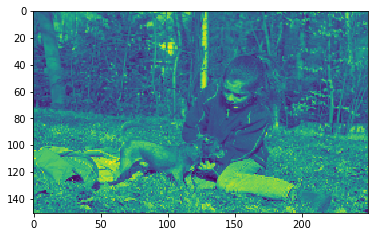

In [13]:
import matplotlib.pyplot as plt
plt.imshow(test_img[0].reshape(151,250)*255)

In [2]:
for i in range(10):
    print('第',i,'轮###################################')
    print(fc[i][0])

第 0 轮###################################
[0.         0.         0.         0.01409694 0.         0.33400336
 0.1848801  0.         0.07424003 0.         0.         0.25113088
 0.09627323 0.         0.09958581 0.13438909 0.         0.1887573
 0.11439046 0.         0.         0.         0.30882064 0.
 0.         0.         0.         0.15994045 0.         0.
 0.05596796 0.12312035 0.3444758  0.         0.03458172 0.00848386
 0.1509659  0.         0.02175374 0.11575228 0.         0.
 0.         0.         0.         0.         0.         0.0890926
 0.18122703 0.08273007 0.         0.21390532 0.07246125 0.0223909
 0.         0.10564062 0.17107518 0.         0.01641385 0.09468123
 0.         0.09177312 0.         0.09115206 0.08075444 0.
 0.         0.11617891 0.         0.13771272 0.01022485 0.42537493
 0.09899035 0.         0.01247919 0.18790686 0.         0.05400959
 0.5243262  0.         0.         0.25085187 0.         0.
 0.         0.19621348 0.07367975 0.         0.         0.117552

In [27]:
b=fc[5]
j=1
soft=[i/sum([math.e**i for i in b[j]]) for i in [math.e**i for i in b[j]]]

In [28]:
soft

[0.008314869628007898,
 0.008314869628007898,
 0.008314869628007898,
 0.008314869628007898,
 0.008314869628007898,
 0.008314869628007898,
 0.008314869628007898,
 0.008325846228381664,
 0.008314869628007898,
 0.008314869628007898,
 0.008314869628007898,
 0.008339212744458728,
 0.008314869628007898,
 0.008314869628007898,
 0.008314869628007898,
 0.008432254263669533,
 0.008473813634116874,
 0.008314869628007898,
 0.008314869628007898,
 0.008345761889330679,
 0.008314869628007898,
 0.008314869628007898,
 0.008703977323167396,
 0.008314869628007898,
 0.008314869628007898,
 0.008314869628007898,
 0.008314869628007898,
 0.008314869628007898,
 0.008314869628007898,
 0.008314869628007898,
 0.008314869628007898,
 0.008314869628007898,
 0.00835072602803053,
 0.008396532193507444,
 0.008387773635240106,
 0.008541573110731218,
 0.008450618197341738,
 0.008314869628007898,
 0.008460414621502467,
 0.008314869628007898,
 0.008314869628007898,
 0.008314869628007898,
 0.008314869628007898,
 0.008314869

In [23]:
-math.log(soft[1])

4.789315651901991

In [5]:
train_summary ##四处权重初始化方差分别为：1, 1, 0.1, 0.1 训练的结果

,batch,loss,accuracy
0,0.0,9597.383789,5/360
1,1.0,22469.695312,4/360
2,2.0,8461.116211,3/360
3,3.0,1211.950195,4/360
4,4.0,192.820450,3/360
5,5.0,6.293942,3/360
6,6.0,8.086734,3/360
7,7.0,11.565230,3/360
8,8.0,11.689877,3/360
9,9.0,6.077818,4/360


In [10]:
train_summary ##四处权重初始化方差分别为：0.01, 0.01, 0.1, 0.1 训练的结果

,batch,loss,accuracy
0,0.0,4.801760,2/360
1,1.0,10.465176,7/360
2,2.0,4.788722,7/360
3,3.0,4.790836,1/360
4,4.0,4.789103,4/360
5,5.0,4.789381,1/360
6,6.0,4.788627,1/360
7,7.0,4.787108,4/360
8,8.0,4.788805,2/360
9,9.0,4.788347,2/360


In [ ]:
train_summary ##四处权重初始化方差分别为：xavier_initializer_conv2d, xavier_initializer_conv2d, xavier_initializer, xavier_initializer 训练的结果

In [1]:
from PIL import Image
import cv2
import tensorflow as tf
import os
import numpy as np
path = "D:\学习笔记\ML-Tensorflow\Images\\n02085620-Chihuahua"
os.chdir(path)
img = cv2.imread("n02085620_242.jpg")
grayed_img =cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
scale_img = cv2.resize(grayed_img,(250,151))
bytes_img = scale_img.astype(np.float32).tobytes()

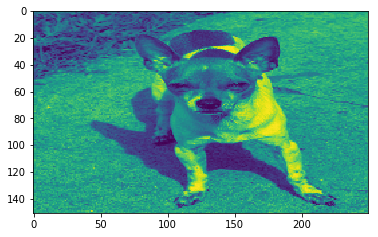

In [4]:
import matplotlib.pyplot as plt
plt.imshow(scale_img)

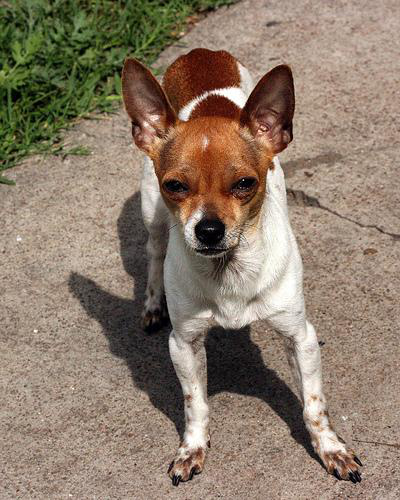

In [4]:
img.